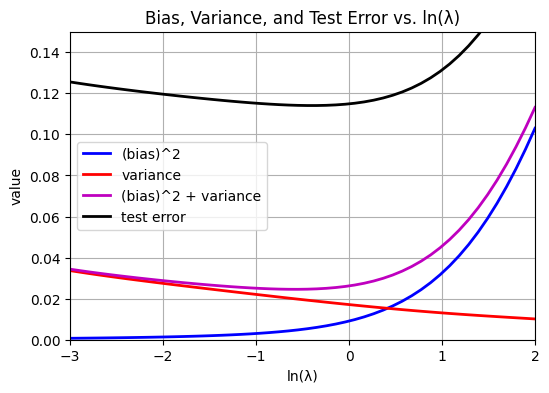

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dataset(N, seed):
    # Generate N points: x ~ U(0,1), t = sin(2*pi*x) + N(0, 0.3)
    np.random.seed(seed)
    x = np.random.uniform(0, 1, N)
    noise = np.random.normal(0, 0.3, N)
    t = np.sin(2 * np.pi * x) + noise
    return x, t

def true_function(x):
    # Noise-free function: h(x)=sin(2*pi*x)
    return np.sin(2 * np.pi * x)

def design_matrix(x, degree, s=0.1):
    # Build the matrix with Gaussian basis functions and a bias term
    mu = np.linspace(0, 1, degree) # evenly spaced
    Phi = []
    for xi in x:
        row = [np.exp(-((xi - center)**2) / (2 * s**2)) for center in mu]
        row.append(1.0)  # bias term
        Phi.append(row)
    return np.array(Phi)

def train_regression(x, t, degree, lambd, s=0.1):
    # Train a regularized linear model
    Phi = design_matrix(x, degree, s)
    A = Phi.T @ Phi + lambd * np.eye(degree + 1)
    w = np.linalg.inv(A) @ Phi.T @ t
    return w

def evaluate_model(L, N, N_test, degree, lambd, s=0.1, test_seed=9999):
    # Compute bias^2, variance, and test error for a given lambda
    w_list = []
    for train_seed in range(L):
        x_train, t_train = generate_dataset(N, train_seed)
        w_list.append(train_regression(x_train, t_train, degree, lambd, s))

    x_test, t_test = generate_dataset(N_test, test_seed)

    h_test = true_function(x_test)

    Phi_test = design_matrix(x_test, degree, s)

    predictions = np.array([Phi_test @ w for w in w_list])

    # avg model output
    fbar = np.mean(predictions, axis=0)
    # bias^2
    bias_sq = np.mean((fbar - h_test)**2)
    # variance
    variance = np.mean(np.mean((predictions - fbar)**2, axis=0))

    mse_per_model = np.mean((predictions - t_test)**2, axis=1)
    test_error = np.mean(mse_per_model)

    return bias_sq, variance, test_error

def main():
    L = 100       # Number of training sets
    N = 25        # Training set size
    N_test = 1000 # Test set size
    degree = 10   # Number of RBF units (excluding bias)
    s = 0.1

    # Dense grid of lambda values (ln(lambda) from -3 to 2)
    lambdas_exp = np.linspace(-3, 2, 50)
    lambdas = np.exp(lambdas_exp)

    biases, variances, errors = [], [], []
    for lam in lambdas:
        b2, var, err = evaluate_model(L, N, N_test, degree, lam, s)
        biases.append(b2)
        variances.append(var)
        errors.append(err)
    bv_sum = [b + v for b, v in zip(biases, variances)]

    plt.figure(figsize=(6, 4))
    plt.plot(lambdas_exp, biases, 'b-', linewidth=2, label='(bias)^2')
    plt.plot(lambdas_exp, variances, 'r-', linewidth=2, label='variance')
    plt.plot(lambdas_exp, bv_sum, 'm-', linewidth=2, label='(bias)^2 + variance')
    plt.plot(lambdas_exp, errors, 'k-', linewidth=2, label='test error')
    plt.xlabel('ln(λ)')
    plt.ylabel('value')
    plt.ylim([0, 0.15])
    plt.xlim([-3, 2])
    plt.legend()
    plt.grid(True)
    plt.title('Bias, Variance, and Test Error vs. ln(λ)')
    plt.show()

if __name__ == "__main__":
    main()